In [1]:
!pip install torchmetrics
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import timm

In [3]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [4]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [5]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [6]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [7]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [8]:
combined_data['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

In [9]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

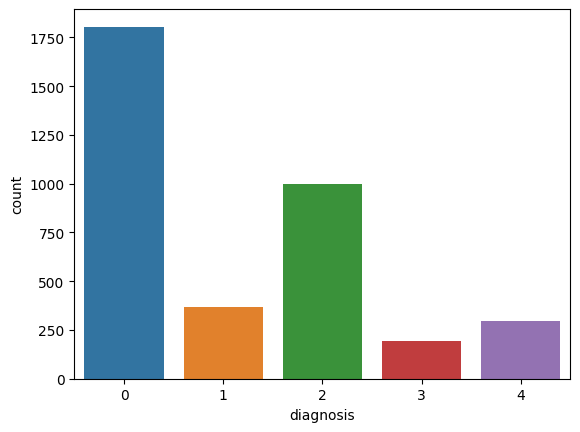

In [10]:
sns.countplot(combined_data,x='diagnosis')

In [11]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [12]:
target_size=500

In [13]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [14]:
downsampled_df['diagnosis'].value_counts()

diagnosis
0    500
2    500
1    370
4    295
3    193
Name: count, dtype: int64

In [15]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [17]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [18]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [19]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

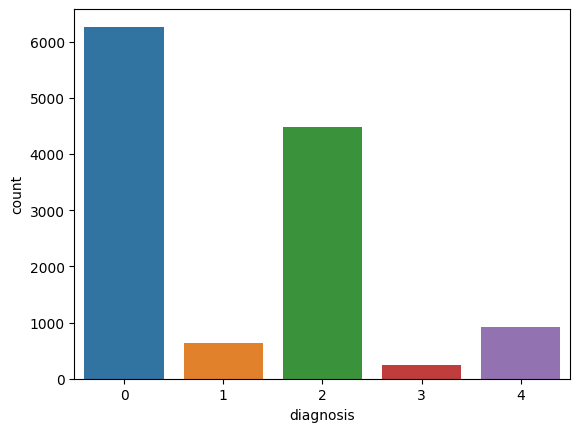

In [20]:
sns.countplot(x='diagnosis',data=labels_df)

In [22]:
labels_df['diagnosis'].value_counts()

diagnosis
0    6266
2    4477
4     913
1     630
3     236
Name: count, dtype: int64

In [23]:
size=800

In [24]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [25]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [26]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [28]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [29]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [30]:
train_df['diagnosis'].value_counts()

diagnosis
1    640
0    640
2    640
4    640
3    342
Name: count, dtype: int64

In [31]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_df['diagnosis']),y=train_df['diagnosis'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [33]:
def crop_image_from_gray(img, tol=5):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark so that we crop out everything
            return img  # Return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [35]:
class DDRDataset(Dataset):
    def __init__(self,images_path,labels, transform=None):
       self.images_path=images_path
       self.labels=labels
       self.transform=transform


    def apply_clahe_rgb(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)


    def crop_image_from_gray(self,img, tol=5):
      if img.ndim == 2:
          mask = img > tol
          return img[np.ix_(mask.any(1), mask.any(0))]
      elif img.ndim == 3:
          gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
          mask = gray_img > tol

          check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
          if check_shape == 0:  # Image is too dark so that we crop out everything
              return img  # Return original image
          else:
              img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
              img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
              img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
              img = np.stack([img1, img2, img3], axis=-1)
          return img

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name=self.labels.iloc[index,0]
        if '.' not in image_name:
            image_name=image_name+'.png'
        image_path=os.path.join(self.images_path,image_name)
        image=cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        label=int(self.labels.iloc[index,1])
        label=torch.tensor(label).long()
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=self.crop_image_from_gray(image)
        image=self.apply_clahe_rgb(image)

        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        return image,label


In [36]:
transforms_train=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=[0.15, 0.15], fill=0,interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomRotation(degrees=[-180, 180],
                                fill=0,interpolation=transforms.InterpolationMode.BICUBIC),

    transforms.RandomAutocontrast(p=0.3),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

    ])
transforms_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [37]:
train_data=DDRDataset(target_dir,train_df,transforms_train)
val_data=DDRDataset(target_dir,val_df,transforms_test)
test_data=DDRDataset(target_dir,test_df,transforms_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
valid_loader=DataLoader(val_data,batch_size=16,shuffle=False)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False)

In [38]:
def denormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor


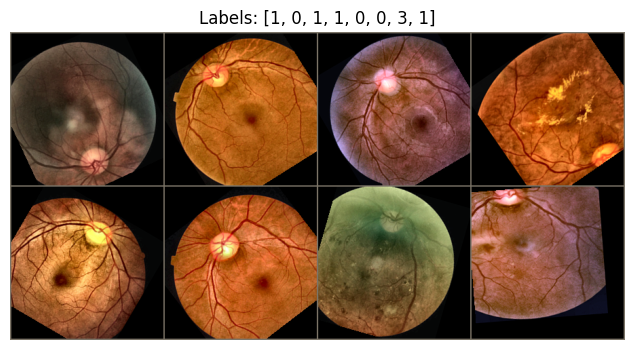

In [39]:
for images, labels in train_loader:
    grid_img =utils.make_grid(images[:8], nrow=4, padding=2)
    grid_img = denormalize(grid_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    np_img = np_img.clip(0, 1)

    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title(f"Labels: {labels[:8].tolist()}")
    plt.axis('off')
    plt.show()
    break

In [40]:
# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, device,
                num_epochs=10, checkpoint_path="mobilenet_dr.pth",
                early_stopping_patience=5):

    best_val_loss = float('inf')
    epochs_no_improve = 0
    l_val_loss = []
    l_train_loss = []

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=1e-6
    )

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        l_train_loss.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_acc = val_correct / total
        l_val_loss.append(avg_val_loss)
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint at epoch {epoch+1}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return l_train_loss, l_val_loss


In [41]:
def test_model(model, test_loader, criterion, device, num_classes=5):
    model.eval()

    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Accuracy: {accuracy.compute().item():.4f}")
    print(f"Precision (weighted): {precision.compute().item():.4f}")
    print(f"Recall (weighted): {recall.compute().item():.4f}")
    print(f"F1 Score (weighted): {f1.compute().item():.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

In [42]:
model = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    num_classes=5,

)

model.to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [43]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,weight_decay=0.05, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.1)

In [45]:
train_loss,val_loss=train_model(model,train_loader,valid_loader,criterion,optimizer,device,num_epochs=20,checkpoint_path="swin_transformer.pth")


Epoch [1/20]


100%|██████████| 182/182 [11:11<00:00,  3.69s/it]


Train Loss: 1.2750, Accuracy: 0.5055


100%|██████████| 23/23 [01:07<00:00,  2.95s/it]


Val Loss: 1.2362, Accuracy: 0.5813
Saved checkpoint at epoch 1

Epoch [2/20]


100%|██████████| 182/182 [11:07<00:00,  3.66s/it]


Train Loss: 1.0949, Accuracy: 0.6261


100%|██████████| 23/23 [01:06<00:00,  2.89s/it]


Val Loss: 1.0719, Accuracy: 0.6474
Saved checkpoint at epoch 2

Epoch [3/20]


100%|██████████| 182/182 [11:02<00:00,  3.64s/it]


Train Loss: 1.0342, Accuracy: 0.6544


100%|██████████| 23/23 [01:06<00:00,  2.91s/it]


Val Loss: 1.1325, Accuracy: 0.5620
No improvement for 1 epochs

Epoch [4/20]


100%|██████████| 182/182 [11:07<00:00,  3.67s/it]


Train Loss: 0.9913, Accuracy: 0.6771


100%|██████████| 23/23 [01:07<00:00,  2.95s/it]


Val Loss: 0.9511, Accuracy: 0.6970
Saved checkpoint at epoch 4

Epoch [5/20]


100%|██████████| 182/182 [11:00<00:00,  3.63s/it]


Train Loss: 0.9543, Accuracy: 0.7071


100%|██████████| 23/23 [01:06<00:00,  2.88s/it]


Val Loss: 0.9376, Accuracy: 0.6970
Saved checkpoint at epoch 5

Epoch [6/20]


100%|██████████| 182/182 [11:17<00:00,  3.72s/it]


Train Loss: 0.9238, Accuracy: 0.7247


100%|██████████| 23/23 [01:08<00:00,  3.00s/it]


Val Loss: 1.0166, Accuracy: 0.6612
No improvement for 1 epochs

Epoch [7/20]


100%|██████████| 182/182 [11:12<00:00,  3.70s/it]


Train Loss: 0.9031, Accuracy: 0.7298


100%|██████████| 23/23 [01:09<00:00,  3.02s/it]


Val Loss: 0.9494, Accuracy: 0.7245
No improvement for 2 epochs

Epoch [8/20]


100%|██████████| 182/182 [11:14<00:00,  3.71s/it]


Train Loss: 0.8567, Accuracy: 0.7560


100%|██████████| 23/23 [01:11<00:00,  3.11s/it]


Val Loss: 1.0014, Accuracy: 0.6501
No improvement for 3 epochs

Epoch [9/20]


100%|██████████| 182/182 [11:19<00:00,  3.73s/it]


Train Loss: 0.8149, Accuracy: 0.7850


100%|██████████| 23/23 [01:06<00:00,  2.90s/it]


Val Loss: 0.9820, Accuracy: 0.6832
No improvement for 4 epochs

Epoch [10/20]


100%|██████████| 182/182 [11:03<00:00,  3.64s/it]


Train Loss: 0.7924, Accuracy: 0.7908


100%|██████████| 23/23 [01:05<00:00,  2.84s/it]

Val Loss: 1.0131, Accuracy: 0.6997
No improvement for 5 epochs
Early stopping triggered at epoch 10


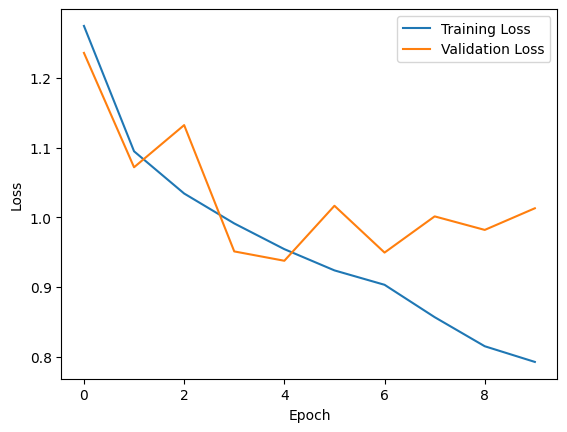

In [49]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

100%|██████████| 23/23 [01:11<00:00,  3.11s/it]


Accuracy: 0.6758
Precision (weighted): 0.7006
Recall (weighted): 0.6758
F1 Score (weighted): 0.6811

Classification Report:
              precision    recall  f1-score   support

           0      0.844     0.812     0.828        80
           1      0.672     0.537     0.597        80
           2      0.622     0.637     0.630        80
           3      0.438     0.727     0.547        44
           4      0.809     0.688     0.743        80

    accuracy                          0.676       364
   macro avg      0.677     0.680     0.669       364
weighted avg      0.701     0.676     0.681       364



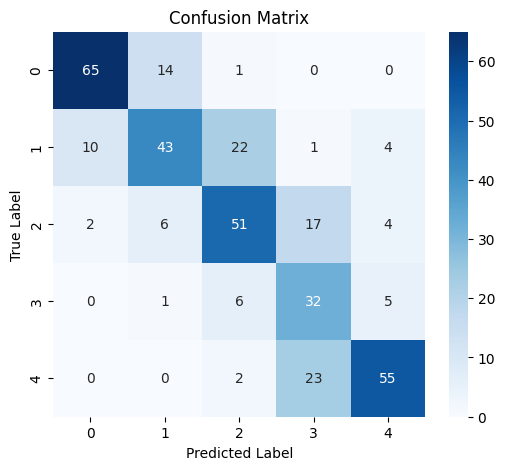

In [48]:
model.load_state_dict(torch.load("swin_transformer.pth"))
test_model(model,test_loader,criterion,device)

In [42]:
model.load_state_dict(torch.load("/kaggle/input/pretrained_model/pytorch/default/1/swin_transformer.pth"))
train_loss,val_loss=train_model(model,train_loader,valid_loader,criterion,optimizer,device,num_epochs=10,checkpoint_path="swin_transformer.pth")


Epoch [1/10]


100%|██████████| 182/182 [10:51<00:00,  3.58s/it]


Train Loss: 0.9545, Accuracy: 0.7150


100%|██████████| 23/23 [01:06<00:00,  2.87s/it]


Val Loss: 0.9874, Accuracy: 0.6612
Saved checkpoint at epoch 1

Epoch [2/10]


100%|██████████| 182/182 [10:52<00:00,  3.58s/it]


Train Loss: 0.9233, Accuracy: 0.7261


100%|██████████| 23/23 [01:05<00:00,  2.86s/it]


Val Loss: 0.9120, Accuracy: 0.7245
Saved checkpoint at epoch 2

Epoch [3/10]


100%|██████████| 182/182 [10:51<00:00,  3.58s/it]


Train Loss: 0.8943, Accuracy: 0.7419


100%|██████████| 23/23 [01:05<00:00,  2.86s/it]


Val Loss: 0.9615, Accuracy: 0.6887
No improvement for 1 epochs

Epoch [4/10]


100%|██████████| 182/182 [10:55<00:00,  3.60s/it]


Train Loss: 0.8543, Accuracy: 0.7698


100%|██████████| 23/23 [01:05<00:00,  2.86s/it]


Val Loss: 0.9655, Accuracy: 0.7218
No improvement for 2 epochs

Epoch [5/10]


100%|██████████| 182/182 [10:54<00:00,  3.60s/it]


Train Loss: 0.8033, Accuracy: 0.7884


100%|██████████| 23/23 [01:05<00:00,  2.85s/it]


Val Loss: 0.9526, Accuracy: 0.7107
No improvement for 3 epochs

Epoch [6/10]


100%|██████████| 182/182 [10:53<00:00,  3.59s/it]


Train Loss: 0.7518, Accuracy: 0.8212


100%|██████████| 23/23 [01:05<00:00,  2.87s/it]


Val Loss: 0.9529, Accuracy: 0.7328
No improvement for 4 epochs

Epoch [7/10]


100%|██████████| 182/182 [10:49<00:00,  3.57s/it]


Train Loss: 0.6988, Accuracy: 0.8494


100%|██████████| 23/23 [01:04<00:00,  2.80s/it]

Val Loss: 0.9884, Accuracy: 0.7218
No improvement for 5 epochs
Early stopping triggered at epoch 7


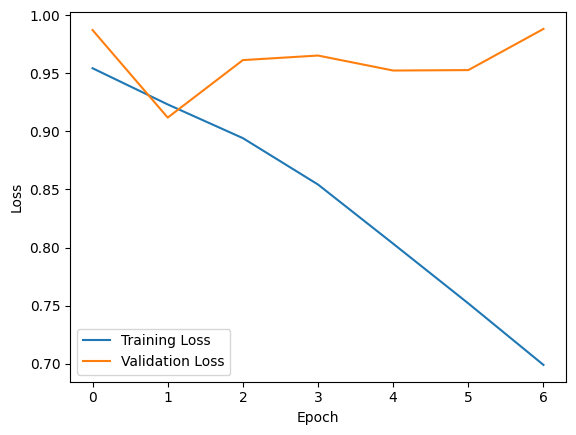

In [43]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
  torch.save(model.state_dict(),'model_saved.pth')

100%|██████████| 23/23 [01:08<00:00,  2.97s/it]


Accuracy: 0.7005
Precision (weighted): 0.7088
Recall (weighted): 0.7005
F1 Score (weighted): 0.7008

Classification Report:
              precision    recall  f1-score   support

           0      0.823     0.812     0.818        80
           1      0.606     0.750     0.670        80
           2      0.698     0.550     0.615        80
           3      0.542     0.591     0.565        44
           4      0.800     0.750     0.774        80

    accuracy                          0.701       364
   macro avg      0.694     0.691     0.689       364
weighted avg      0.709     0.701     0.701       364



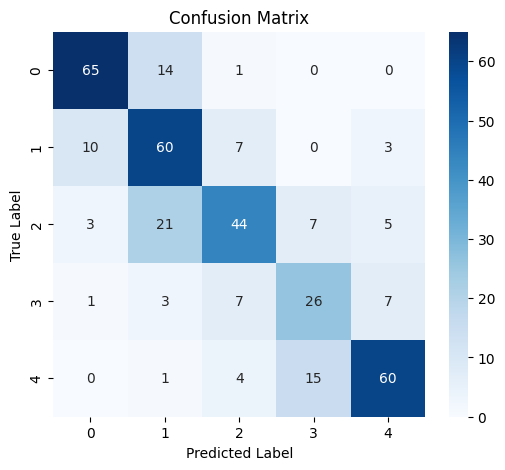

In [44]:
model.load_state_dict(torch.load("swin_transformer.pth"))
test_model(model,test_loader,criterion,device)

100%|██████████| 23/23 [01:08<00:00,  2.99s/it]


Accuracy: 0.7225
Precision (weighted): 0.7285
Recall (weighted): 0.7225
F1 Score (weighted): 0.7234

Classification Report:
              precision    recall  f1-score   support

           0      0.835     0.825     0.830        80
           1      0.653     0.775     0.709        80
           2      0.708     0.637     0.671        80
           3      0.543     0.568     0.556        44
           4      0.819     0.738     0.776        80

    accuracy                          0.723       364
   macro avg      0.712     0.709     0.708       364
weighted avg      0.729     0.723     0.723       364



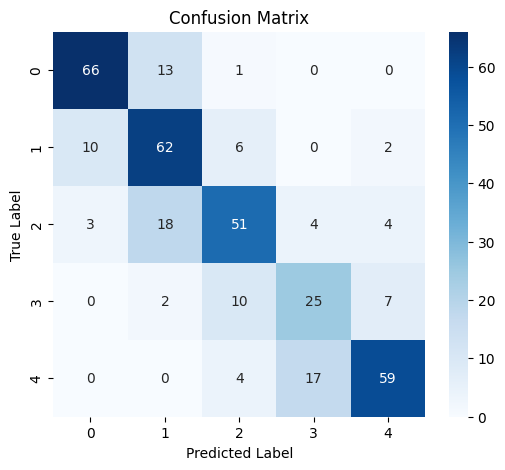

In [44]:
model.load_state_dict(torch.load("/kaggle/input/swin_transformer/pytorch/default/1/swin_transformer (3).pth"))
test_model(model,test_loader,criterion,device)

In [45]:
 
train_loss,val_loss=train_model(model,train_loader,valid_loader,criterion,optimizer,device,num_epochs=10,checkpoint_path="swin_transformer.pth")


Epoch [1/10]


100%|██████████| 182/182 [10:31<00:00,  3.47s/it]


Train Loss: 0.8620, Accuracy: 0.7615


100%|██████████| 23/23 [01:02<00:00,  2.72s/it]


Val Loss: 0.9759, Accuracy: 0.7218
Saved checkpoint at epoch 1

Epoch [2/10]


100%|██████████| 182/182 [10:29<00:00,  3.46s/it]


Train Loss: 0.8503, Accuracy: 0.7677


100%|██████████| 23/23 [01:02<00:00,  2.71s/it]


Val Loss: 0.9699, Accuracy: 0.6887
Saved checkpoint at epoch 2

Epoch [3/10]


100%|██████████| 182/182 [10:30<00:00,  3.46s/it]


Train Loss: 0.8129, Accuracy: 0.7881


100%|██████████| 23/23 [01:02<00:00,  2.70s/it]


Val Loss: 0.9658, Accuracy: 0.7245
Saved checkpoint at epoch 3

Epoch [4/10]


100%|██████████| 182/182 [10:28<00:00,  3.45s/it]


Train Loss: 0.7784, Accuracy: 0.8074


100%|██████████| 23/23 [01:03<00:00,  2.74s/it]


Val Loss: 0.9541, Accuracy: 0.7080
Saved checkpoint at epoch 4

Epoch [5/10]


100%|██████████| 182/182 [10:28<00:00,  3.45s/it]


Train Loss: 0.7337, Accuracy: 0.8343


100%|██████████| 23/23 [01:02<00:00,  2.72s/it]


Val Loss: 0.9244, Accuracy: 0.7493
Saved checkpoint at epoch 5

Epoch [6/10]


100%|██████████| 182/182 [10:30<00:00,  3.46s/it]


Train Loss: 0.6716, Accuracy: 0.8639


100%|██████████| 23/23 [01:02<00:00,  2.71s/it]


Val Loss: 0.9645, Accuracy: 0.7107
No improvement for 1 epochs

Epoch [7/10]


100%|██████████| 182/182 [10:29<00:00,  3.46s/it]


Train Loss: 0.6168, Accuracy: 0.8987


100%|██████████| 23/23 [01:01<00:00,  2.67s/it]


Val Loss: 0.9879, Accuracy: 0.7218
No improvement for 2 epochs

Epoch [8/10]


100%|██████████| 182/182 [10:29<00:00,  3.46s/it]


Train Loss: 0.5829, Accuracy: 0.9163


100%|██████████| 23/23 [01:02<00:00,  2.70s/it]


Val Loss: 1.0097, Accuracy: 0.7273
No improvement for 3 epochs

Epoch [9/10]


100%|██████████| 182/182 [10:30<00:00,  3.46s/it]


Train Loss: 0.5464, Accuracy: 0.9414


100%|██████████| 23/23 [01:02<00:00,  2.74s/it]


Val Loss: 1.0108, Accuracy: 0.7383
No improvement for 4 epochs

Epoch [10/10]


100%|██████████| 182/182 [10:34<00:00,  3.49s/it]


Train Loss: 0.5288, Accuracy: 0.9483


100%|██████████| 23/23 [01:03<00:00,  2.75s/it]

Val Loss: 1.0175, Accuracy: 0.7383
No improvement for 5 epochs
Early stopping triggered at epoch 10


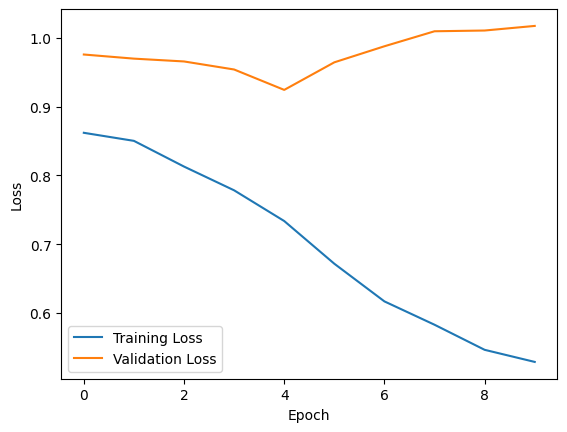

In [48]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

100%|██████████| 23/23 [01:08<00:00,  2.98s/it]


Accuracy: 0.7143
Precision (weighted): 0.7222
Recall (weighted): 0.7143
F1 Score (weighted): 0.7161

Classification Report:
              precision    recall  f1-score   support

           0      0.829     0.850     0.840        80
           1      0.690     0.613     0.649        80
           2      0.611     0.688     0.647        80
           3      0.569     0.659     0.611        44
           4      0.843     0.738     0.787        80

    accuracy                          0.714       364
   macro avg      0.708     0.709     0.707       364
weighted avg      0.722     0.714     0.716       364



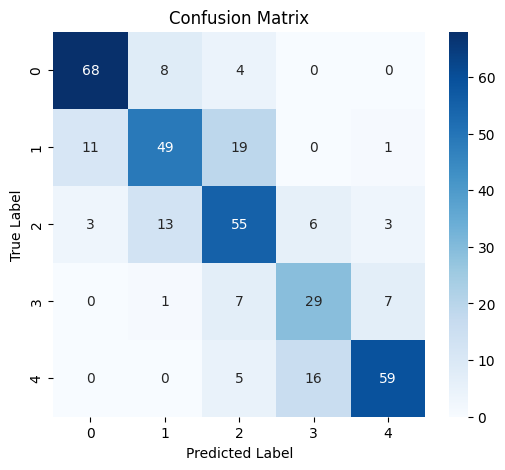

In [47]:
model.load_state_dict(torch.load("swin_transformer.pth"))
test_model(model,test_loader,criterion,device)